## LeNet

LeNet，是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），目的是识别图像 [LeCun et al., 1998](https://zh-v2.d2l.ai/chapter_references/zreferences.html#lecun-bottou-bengio-ea-1998) 中的手写数字。当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究。

当时，LeNet取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。LeNet被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。

In [14]:
import torch
from torch import nn
import sys
sys.path.append('..')
import d2l
import utils

### 1.Fashion-MNIST

- 60,000个训练数据
- 10,000个测试数据
- 灰度图像大小$28\times28$，已经scale好，放到图像正中间了
- 10类

### 2.网络结构

总体来看，LeNet（LeNet-5）由两个部分组成：
- 卷积编码器：由两个卷积层组成；
- 全连接层密集块：由三个全连接层组成。

![](https://zh-v2.d2l.ai/_images/lenet.svg)
- 每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层。请注意，虽然ReLU和最大汇聚层更有效，但它们在20世纪90年代还没有出现。
  - 每个卷积层使用 5×5 卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。
  - 每个 2×2 池操作（步骤2）通过空间下采样将维数减少4倍。
- 卷积的输出，在输入到全连接层之前，需要展平：$(batch\_size, channel\_size, h, w) \to (batch\_size, -1)$

In [10]:
class LeNet_5(nn.Module):
    '''LeNet-5的pytorch实现，去掉了最后的高斯激活'''
    def __init__(self):
        # 1.调用父类的初始化
        super(LeNet_5, self).__init__()
        # 2.定义我们需要哪些函数
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.avgpool2d = nn.AvgPool2d(kernel_size=2, stride=2)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()     # 展平dim[1:]
        self.linear1 = nn.Linear(16*5*5, 120)
        self.Linear2 = nn.Linear(120, 84)
        self.Linear3 = nn.Linear(84, 10)
    def forward(self, X):
        '''定义前向计算过程'''
        # 卷积核1
        y = self.conv1(X.view(-1, 1, 28, 28))
        y = self.sigmoid(y)
        y = self.avgpool2d(y)
        # 卷积核2
        y = self.conv2(y)
        y = self.sigmoid(y)
        y = self.avgpool2d(y)
        # 展平、线性层
        y = self.flatten(y)
        y = self.linear1(y)
        y = self.sigmoid(y)
        y = self.Linear2(y)
        y = self.sigmoid(y)
        y = self.Linear3(y)
        return y

In [11]:
X = torch.rand(size=(1,1,28,28), dtype=torch.float32)
net = LeNet_5()
Y = net(X)
print(net)          # 自定义模型时，如何让输出有序？

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2d): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (sigmoid): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=400, out_features=120, bias=True)
  (Linear2): Linear(in_features=120, out_features=84, bias=True)
  (Linear3): Linear(in_features=84, out_features=10, bias=True)
)


In [12]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


### 3.网络训练：Fashion-MNIST

In [13]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size, root='../data')

评估函数：使用GPU

In [15]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    '''使用GPU计算模型在数据集上的精度'''
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device    # 不指定计算设备，则使用模型所在的设备
    metric = utils.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy_ch3(net(X), y), y.numel())
    return metric[0] / metric[1]

训练函数：使用GPU

In [16]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = utils.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = utils.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = utils.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy_ch3(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

训练和评估LeNet-5模型

loss 0.401, train acc 0.855, test acc 0.840
74873.2 examples/sec on cuda:0


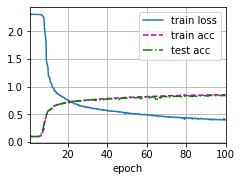

In [18]:
net = LeNet_5()
lr, num_epochs = 0.09, 100
train_ch6(net, train_iter, test_iter, num_epochs, lr, device=utils.try_gpu())

### 总结

- 在卷积神经网络中，我们组合使用卷积层、非线性激活函数和汇聚层；
- 为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数；
- 在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理，转换到类别空间；
- LeNet是最早发布的卷积神经网络之一。